# Описание проекта

Нужно подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


**ОПИСАНИЕ ДАННЫХ** <br>

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации)
* Sulphate — сульфат (на данном производстве сульфид натрия)
* Depressant — депрессант (силикат натрия)
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Парметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Возможные значения для блока [этап]:**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
**Возможные значения для блока [тип_параметра]**:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики



**СОДЕРЖАНИЕ**

 [Шаг 1. Подготовка данных](#step1)
 
 [Шаг 2. Анализ данных](#step2)
 
 [Шаг 3. Построение модели](#step3)
 
 [Общий вывод](#step4)

<a id = 'step1'></a>
# Шаг 1. Подготовка данных

**1.1. Открываем и изучаем файлы**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import os
import plotly.graph_objs as go


from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from hyperopt import hp
from xgboost import XGBRegressor

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

In [3]:
def read(name_of_file):
    if os.path.exists(name_of_file):
        return pd.read_csv(name_of_file)
    else:
        return pd.read_csv(f'/datasets/{name_of_file}')

In [4]:
df_train = read('gold_recovery_train_new.csv')
df_test = read('gold_recovery_test_new.csv')
df_full = read('gold_recovery_full_new.csv')

In [5]:
# display(ProfileReport(df_full, 
#                            title="Исходные данные", 
#                            explorative=False, 
#                            html={'style':{'full_width':True}}, 
#                            minimal=True))

**1.2. Проверяем, что эффективность обогащения рассчитана правильно. Найходим MAE между нашими расчётами и значением признака.**

In [6]:
def recovery(C,F,T):
    r = C*(F-T)/(F*(C-T))*100
    return r

In [7]:
c, f, t  = df_train['rougher.output.concentrate_au'], df_train['rougher.input.feed_au'], df_train['rougher.output.tail_au']
rec = recovery(c, f, t)
print("Совпадающих значений: {:.2%}".format(sum(abs(df_train['rougher.output.recovery'] - rec) < 10**(-4))/len(df_train['rougher.output.recovery'])))
print("Среднее:", rec.mean())
print("MAE:", mean_absolute_error(df_train['rougher.output.recovery'].dropna(),
                                                                  rec.dropna()))
print("--------------------------")
print("Пропуски в расчете:", rec.isna().sum())
print("Пропуски в full DataFrame:", df_train['rougher.output.recovery'].isna().sum())

Совпадающих значений: 100.00%
Среднее: 82.70450164550293
MAE: 9.73512347450521e-15
--------------------------
Пропуски в расчете: 0
Пропуски в full DataFrame: 0


**1.3. Анализируем признаки, недоступные в тестовой выборке**

In [8]:
missing = set(df_train.columns) - set(df_test.columns)
missing

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**1.4. Предобработка данных**

In [9]:
data = {'Train': df_train, 'Test': df_test, 'Full': df_full}

for k,v in data.items():
    print(k)
    print('---------------------')
    print("Размер:", v.shape)
    print('Пропуски:', v.isna().sum().sum())
    print('Дубликаты:',v.duplicated().sum())
    print()
    v["date"] = pd.to_datetime(v["date"]) 
    

Train
---------------------
Размер: (14149, 87)
Пропуски: 4100
Дубликаты: 0

Test
---------------------
Размер: (5290, 53)
Пропуски: 90
Дубликаты: 0

Full
---------------------
Размер: (19439, 87)
Пропуски: 4481
Дубликаты: 0



<div class="alert alert-block alert-info">
    
**Комментарий**

Проведя исследование, мы обнаружили что многие признаки имеют скошенные распределения. Оказалось, что в данных множество пропсуков - бороться с ними мы будем позже. Также мы провели анализ расчета эффективности обогащения - она выполнена корректно. Выяснили, что в тестовой выборке отсутствуют признаки, которые отвечают за описание характеристик металлов на различных этапах обработки, а также целевые признаки.

<a id = 'step2'></a>
# Шаг 2. Анализ данныx

**2.1. Cмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки**

In [10]:
metals = {'Золото': 'au', 'Серебро': 'ag', 'Свинец': 'pb'}

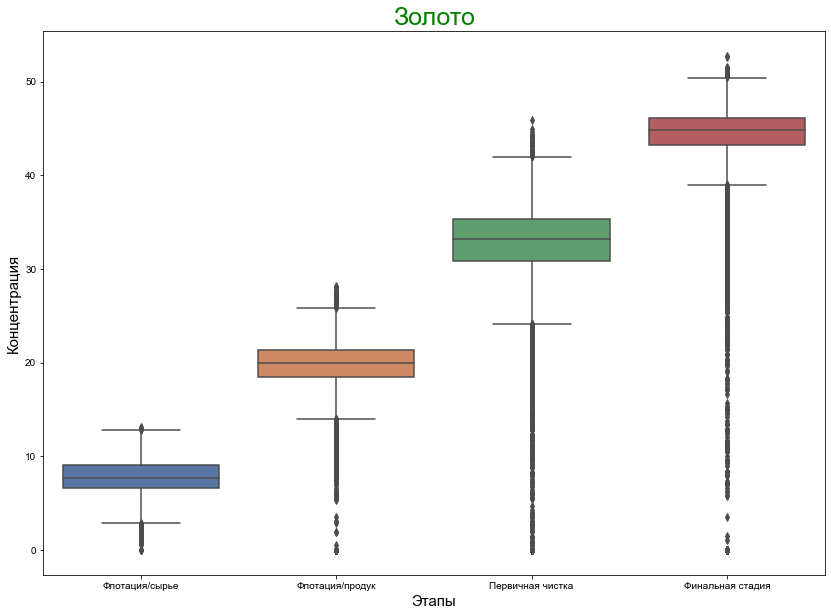

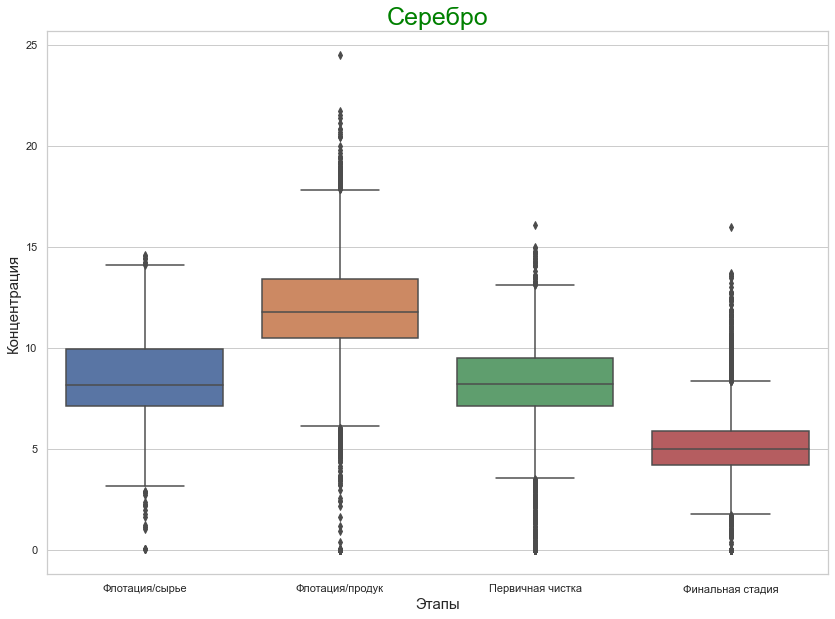

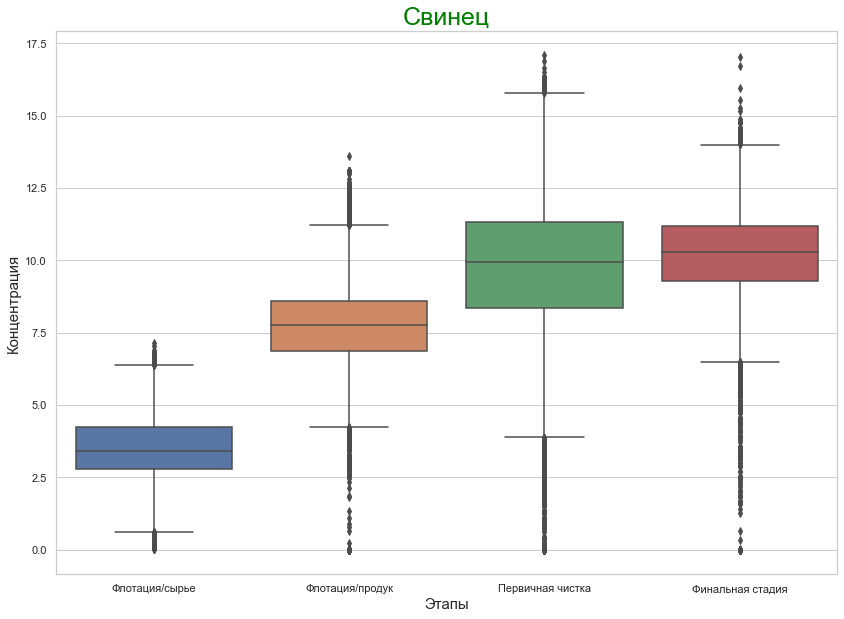

In [11]:
for metal in metals:
    d = pd.DataFrame()
    for step in ['rougher.input.feed_'+metals[metal], 'rougher.output.concentrate_'+metals[metal], 
                 'primary_cleaner.output.concentrate_'+metals[metal], 'final.output.concentrate_'+metals[metal]]:
        d = pd.concat([d,df_train[step]], axis=1)
    d.columns = ['Флотация/сырье','Флотация/продук','Первичная чистка','Финальная стадия']    
    plt.figure(figsize=(14, 10))
    plt.title(metal, fontsize=25, color='green')
    sns.set_theme(style="whitegrid")
    s = sns.boxplot(data=d)
    s.set_xlabel('Этапы', fontsize=15) 
    s.set_ylabel('Концентрация',fontsize=15)  

<div class="alert alert-block alert-info">
    
**Комментарий**

Концентрация золота увеличивается на каждом этапе очистки. Медианное значение финального концентрата около 45.<br>
Концентрация серебра максимальна в черновом концентрате после флотации.  
Концентрация свинца также возрастает на каждом этапе, на втором этапе очистки совсем немного увеличивается медиана, но заметно снижается разброс значений.


**2.2. Сравнивниваем распределения размеров гранул сырья на обучающей и тестовой выборках**

In [14]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_train['rougher.input.feed_size'],histnorm='percent', name="train"))
fig.add_trace(go.Histogram(x=df_test['rougher.input.feed_size'], histnorm='percent', name="test"))

fig.update_layout(
    title_text='Distribution of feed size', 
    xaxis_title_text='Value', 
    yaxis_title_text='Count', 
    #bargap=0, 
    #bargroupgap=0.1 
)

fig.show()

<div class="alert alert-block alert-info">
    
**Комментарий**
    
Внешне распределения выглядят примерно одинаково, разница только в плотностях из-за размеров выборок.

In [15]:
from scipy import stats as st
st.kstest(df_train['rougher.input.feed_size'],df_test['rougher.input.feed_size']).pvalue < 0.01

True

<div class="alert alert-info">
    
**Комментрарий**
    
Значение pvalue говорит о том, что выборки принадлежат разным распредлениеям (или одному, но с другими параметрами)

**2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратаx**

In [16]:
stages = pd.DataFrame()

stages['Сырье'] = df_full[['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb']].sum(axis=1)
stages['Черновой концентрат'] = df_full[['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb']].sum(axis=1)
stages['После очистки'] = df_full[['primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb']].sum(axis=1)
stages['Финальный концентрат'] = df_full[['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']].sum(axis=1)


In [17]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=stages['Сырье'], name='Сырье'))
fig.add_trace(go.Histogram(x=stages['Черновой концентрат'], name='Черновой концентрат'))
fig.add_trace(go.Histogram(x=stages['После очистки'], name='После очистки'))
fig.add_trace(go.Histogram(x=stages['Финальный концентрат'], name='Финальный концентрат'))               
 
              
fig.update_layout(
    title_text='Суммарная концентрация', 
    yaxis_title_text='Концентрация', 
    bargap=0, 
    bargroupgap=0 
)

fig.show()              

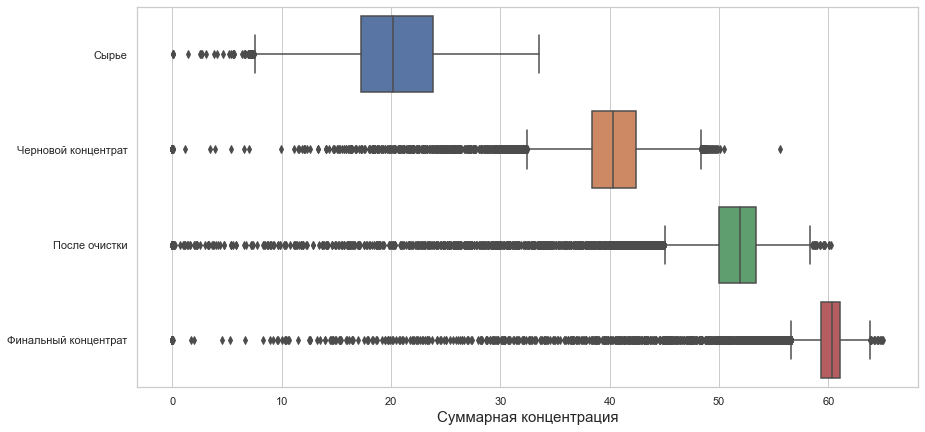

In [16]:
plt.figure(figsize=(14,7))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=stages, orient='h')
ax.set_xlabel('Суммарная концентрация', fontsize=15) 
plt.show()

<div class="alert alert-block alert-info">
    
**Комментарий**

По распределениям и boxplot'ам видно, что концентрации металлов имеют большой разброс и нулевые значения (последнее вполне реально). Выбросы будем чистить дальше.

In [17]:
stage = [
        'rougher.input.feed',
        'rougher.output.concentrate', 
        'primary_cleaner.output.concentrate', 
        'final.output.concentrate' 
]

for s in stage:
    print('Стадия -', s)
    print('-------------------------------------------')
    if len(df_train[df_train[s+'_au'] == 0].index) == 0 and len(df_train[df_train[s+'_ag'] == 0].index) == 0 and len(df_train[df_train[s+'_pb'] == 0].index) == 0:
        print('Нет строк, где концентрация равна 0')
        print()
    else:
        num = len(set(df_train[df_train[s+'_au'] == 0].index) - set(df_train[df_train[s+'_ag'] == 0].index) - set(df_train[df_train[s+'_pb'] == 0].index))
        if num == 0:
            print('Кол-во строк, где концентрация равна 0:',len(df_train[df_train[s+'_au'] == 0].index))
            print()

Стадия - rougher.input.feed
-------------------------------------------
Нет строк, где концентрация равна 0

Стадия - rougher.output.concentrate
-------------------------------------------
Кол-во строк, где концентрация равна 0: 297

Стадия - primary_cleaner.output.concentrate
-------------------------------------------
Кол-во строк, где концентрация равна 0: 74

Стадия - final.output.concentrate
-------------------------------------------
Кол-во строк, где концентрация равна 0: 58



In [18]:
columns = []
for s in stage:
    for metal in metals:
        columns.append(s + '_' + metals[metal])

#выбрасываем значения, выходящие за "усы" боксплотов     
for col in columns:
    
    q1 = df_train[df_train[col]!=0][col].quantile(0.25)
    q3 = df_train[df_train[col]!=0][col].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    df_train[col] = df_train[col].apply(lambda x: x if ((x >= low) & (x <= high)) else np.nan)
    #df_train[col] = df_train[col].apply(lambda x: x if (((x >= low) & (x <= high)) | (x == 0.0)) else np.nan)

In [19]:
#NEW
# for col in columns:
#     df_train.drop(df_train[df_train[col]==0].index, axis=0, inplace=True)
# for col in columns:
#     if len(df_train[df_train[col] == 0]) == 0:
#         print('clear')
#     else:
#         print('zero values exists')

In [20]:
stages = pd.DataFrame()

stages['Сырье'] = df_train[['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb']].sum(axis=1)
stages['Черновой концентрат'] = df_train[['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb']].sum(axis=1)
stages['После очистки'] = df_train[['primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb']].sum(axis=1)
stages['Финальный концентрат'] = df_train[['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']].sum(axis=1)



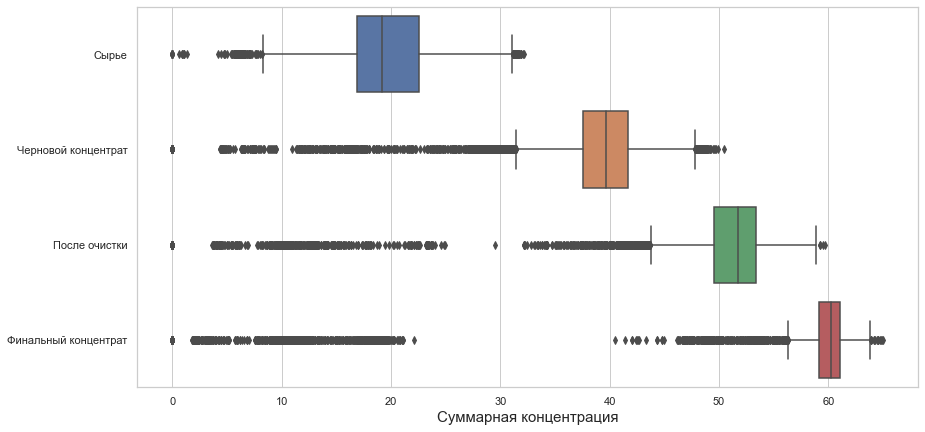

In [21]:
plt.figure(figsize=(14,7))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=stages, orient='h')
ax.set_xlabel('Суммарная концентрация', fontsize=15) 
plt.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=stages['Сырье'], name='Сырье'))
fig.add_trace(go.Histogram(x=stages['Черновой концентрат'], name='Черновой концентрат'))
fig.add_trace(go.Histogram(x=stages['После очистки'], name='После очистки'))
fig.add_trace(go.Histogram(x=stages['Финальный концентрат'], name='Финальный концентрат'))               
 
              
fig.update_layout(
    title_text='Суммартная концентрация', 
    yaxis_title_text='Концентрация', 
    bargap=0, 
    bargroupgap=0 
)

fig.show()              

In [23]:
for col in columns:
    if len(df_train[df_train[col] == 0]) == 0:
        print('clear')
    else:
        print('zero values exists')

clear
clear
clear
clear
clear
clear
clear
clear
clear
clear
clear
clear


In [24]:
#удалим из списка отсутсвующих колонок таргеты, чтобы потом не удалить их из трейна
missing = set(missing) - set(['rougher.output.recovery', 'final.output.recovery'])

In [25]:
#удаление лишних колонок
df_full = df_full.drop(missing, axis=1) 
df_train = df_train.drop(missing, axis=1) 

In [26]:
#заполнение nan'ов
# df_full = df_full.fillna(axis = 0, method="ffill")

# df_train = df_full.merge(df_train[['date']], on='date')[df_full.columns]

# df_test = df_full.merge(df_test[['date']], on='date')[df_full.columns]

In [27]:
#удаление nan'ов
df_full = df_full.dropna(axis = 0)

df_train = df_full.merge(df_train[['date']], on='date')[df_full.columns]

df_test = df_full.merge(df_test[['date']], on='date')[df_full.columns]

<a id = 'step3'></a>
# 3. Построение модели

**3.1.Функция для вычисления итоговой sMAPE**

In [28]:
def smape(target,predict):
     return (abs(target-predict)/((abs(target)+abs(predict))/2)).sum()/len(target)*100  
    
def smape_final(func, X, y, **kwargs):
    y_pred = func.predict(X)
    return 0.25 * smape(y['rougher.output.recovery'].values,y_pred[:,0]) + 0.75 * smape(y['final.output.recovery'],y_pred[:,1])

In [29]:
#NEW
#метрика, умноженная на -1
def smape_final_2(func, X, y, **kwargs):
    y_pred = func.predict(X)
    return -1*(0.25 * smape(y['rougher.output.recovery'].values,y_pred[:,0]) + 0.75 * smape(y['final.output.recovery'],y_pred[:,1]))

In [30]:
#функция для разделения данных на features и target и их шкалирования 
def split_and_scale(train, test):
    
    """
    splits train and test
    to features and targets
    """
    
    # train выборка
    features_train = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
    target_train = train[['rougher.output.recovery', 'final.output.recovery']]

    # test выборка
    features_test = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
    target_test = test[['rougher.output.recovery','final.output.recovery']]
    
    scaler = MinMaxScaler()
    cols_train = features_train.columns
    cols_test = features_test.columns
    
    features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train[cols_train]))
    features_test_scaled = pd.DataFrame(scaler.transform(features_test[cols_test]))
    
    
    return features_train_scaled, target_train, features_test_scaled, target_test

In [31]:
features_train, target_train, features_test, target_test = split_and_scale(df_train, df_test)

**3.2. Обучаем разные модели и оцениваем их качество кросс-валидацией. Выбераем лучшую модель и проверяем её на тестовой выборке**

In [32]:
#в скоринге метрика, умноженная на -1
from sklearn.multioutput import MultiOutputRegressor

model_and_parameters = [
                            
                            (Lasso(random_state=123), 
                                     # params
                                     {'alpha': np.linspace(0.1, 2.0, 20)}),
                            
                            (Ridge(random_state=123), 
                                     
                                     {'alpha': np.linspace(0.2, 10.0, 50)}),
    
                            (RandomForestRegressor(random_state=123,n_jobs=-1),
                                    
                                   {'n_estimators' : [i for i in range(25,65,10)],
                                     'max_depth' : [i for i in range(4,10,2)]}),
    
                            (XGBRegressor(random_state =123, n_jobs=-1),
                             
                                   {'n_estimators' : [i for i in range(10,35,10)],
                                     'max_depth' : [i for i in range(2,10,2)]})
                            ]
params = {}
for i, (model, p) in enumerate(model_and_parameters):
    #grid = GridSearchCV(model, p, cv=5,scoring = make_scorer(smape_final, greater_is_better=False))
    grid = GridSearchCV(model, p, cv=5,verbose=2, scoring = smape_final_2)
    grid.fit(features_train, target_train)
    params[i] = grid.best_params_
   

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.3s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.3s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.1s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.3; total time=   0.0s
[CV] END ......................................

[CV] END ..........................................alpha=0.8; total time=   0.0s
[CV] END ..........................................alpha=0.8; total time=   0.0s
[CV] END ..........................................alpha=0.8; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=5.800000000000001; total time=   0.0s
[CV] END ............................alpha=5.800000000000001; total time=   0.0s
[CV] END ............................alpha=6.000000000000001; total time=   0.0s
[CV] END ............................alpha=6.000000000000001; total time=   0.0s
[CV] END ............................alpha=6.000000000000001; total time=   0.0s
[CV] END ............................alpha=6.000000000000001; total time=   0.0s
[CV] END ............................alpha=6.000000000000001; total time=   0.0s
[CV] END ..........................................alpha=6.2; total time=   0.0s
[CV] END ..........................................alpha=6.2; total time=   0.0s
[CV] END ..........................................alpha=6.2; total time=   0.0s
[CV] END ..........................................alpha=6.2; total time=   0.0s
[CV] END ..........................................alpha=6.2; total time=   0.0s
[CV] END ...................

[CV] END .......................max_depth=4, n_estimators=25; total time=   1.2s
[CV] END .......................max_depth=4, n_estimators=25; total time=   0.6s
[CV] END .......................max_depth=4, n_estimators=25; total time=   0.6s
[CV] END .......................max_depth=4, n_estimators=25; total time=   0.6s
[CV] END .......................max_depth=4, n_estimators=25; total time=   0.7s
[CV] END .......................max_depth=4, n_estimators=35; total time=   0.8s
[CV] END .......................max_depth=4, n_estimators=35; total time=   0.8s
[CV] END .......................max_depth=4, n_estimators=35; total time=   0.8s
[CV] END .......................max_depth=4, n_estimators=35; total time=   0.8s
[CV] END .......................max_depth=4, n_estimators=35; total time=   0.7s
[CV] END .......................max_depth=4, n_estimators=45; total time=   0.9s
[CV] END .......................max_depth=4, n_estimators=45; total time=   0.9s
[CV] END ...................

[CV] END .......................max_depth=6, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=6, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=6, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=6, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=8, n_estimators=20; total time=   0.9s
[CV] END .......................max_depth=8, n_estimators=20; total time=   0.9s
[CV] END .......................max_depth=8, n_estimators=20; total time=   0.9s
[CV] END ...................

In [33]:
params

{0: {'alpha': 0.1},
 1: {'alpha': 10.0},
 2: {'max_depth': 6, 'n_estimators': 55},
 3: {'max_depth': 2, 'n_estimators': 10}}

In [34]:
best_models = (LinearRegression(), Lasso(random_state=123, alpha=params[0]['alpha']), Ridge(random_state=123, alpha=params[1]['alpha']), RandomForestRegressor(random_state=123, max_depth=params[2]['max_depth'], n_estimators=params[2]['n_estimators'], n_jobs=-1),XGBRegressor(random_state=123, max_depth=params[3]['max_depth'], n_estimators=params[3]['n_estimators'],n_jobs=-1))
names = ['Linear Regression','Lasso','Ridge','Random Forest','XGBoost']

**Cross Validation witn sMAPE-score in python**

In [35]:
for model, name in zip(best_models,names):
    scores = []
    sample_size = len(df_train) // 5
    k = 1
    for i in range(0,len(df_train), sample_size):
        if k == 5: 
            valid_indexes = df_train.index[i:]
            train_indexes = pd.Series(df_train.index[:i])
        else:
            valid_indexes = df_train.index[i: i + sample_size]
            train_indexes = pd.concat([pd.Series(df_train.index[:i]), pd.Series(df_train.index[i + sample_size:])])

        f_valid = features_train.loc[valid_indexes]
        t_valid = target_train.loc[valid_indexes]
    
        f_train = features_train.loc[train_indexes]
        t_train = target_train.loc[train_indexes]

        model = model
        model.fit(f_train, t_train)

        scores.append(smape_final(model,f_valid,t_valid))
        if k == 5:
            break
        k+=1
    
    print(name)
    print('Средняя оценка качества модели: {:.2f}'.format(pd.Series(scores).mean()))
    print()
    


Linear Regression
Средняя оценка качества модели: 10.93

Lasso
Средняя оценка качества модели: 9.45

Ridge
Средняя оценка качества модели: 10.28

Random Forest
Средняя оценка качества модели: 9.52

XGBoost
Средняя оценка качества модели: 9.95



**Cross Validation witn sMAPE-score in Sklearn**

In [36]:
for model, name in zip(best_models,names):
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring = smape_final)
    final_score = scores.mean()
    print(name)
    print('Средняя оценка качества модели: {:.2f}'.format(final_score))
    print()

Linear Regression
Средняя оценка качества модели: 10.93

Lasso
Средняя оценка качества модели: 9.44

Ridge
Средняя оценка качества модели: 10.28

Random Forest
Средняя оценка качества модели: 9.54

XGBoost
Средняя оценка качества модели: 10.17



**Random Forest на тестовой выборке**

In [37]:
model = RandomForestRegressor(random_state=123, max_depth=params[2]['max_depth'], n_estimators=params[2]['n_estimators'], n_jobs=-1)
model.fit(features_train, target_train)
print('sMAPE: {:.2f}'.format(smape_final(model,features_test,target_test)))

sMAPE: 9.38


**Lasso на тестовой выборке**

In [38]:
model = Lasso(alpha=0.1)
model.fit(features_train, target_train)
print('sMAPE: {:.2f}'.format(smape_final(model,features_test,target_test)))

sMAPE: 8.24


**XGBoost на тестовой выборке**

In [39]:
model = XGBRegressor(random_state=123, max_depth=params[3]['max_depth'], n_estimators=params[3]['n_estimators'], n_jobs=-1)
model.fit(features_train, target_train)
print('sMAPE: {:.2f}'.format(smape_final(model,features_test,target_test)))

sMAPE: 9.89


**Проверка модели на адекватность**

In [40]:
dmb_median = DummyRegressor(strategy="median")
dmb_median.fit(features_train, target_train)
print('sMAPE: {:.2f}'.format(smape_final(dmb_median,features_test,target_test)))

sMAPE: 9.08


In [41]:
dmb_mean = DummyRegressor(strategy="mean")
dmb_mean.fit(features_train, target_train)
print('sMAPE: {:.2f}'.format(smape_final(dmb_mean,features_test,target_test)))

sMAPE: 9.74


<a id = 'step4'></a>

<div class="alert alert-block alert-info">
    
<h2> Общий вывод <a class="tocSkip"></h2>
    
В данной работе в нашем распоряжении были данные, предоставлленные "Цифрой", содержащие информацию с параметрами добычи и очистки золотосодержащей руды. Мы должны были предсказать сразу две величины: эффективность обогащения чернового концентрата (rougher.output.recovery) и эффективность обогащения финального концентрата (rougher.output.recovery). Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. 

Для этого мы в первую очередь произвели исследовательский анализ данных, проверили их на наличие пропусков и дубликатов. Т.к. в данных было поле с уникальным значением - дата, пропуски заполняли соседними значениями. Одним из замечаний к данным было большое количество выбросов. Мы пострались от них избавиться.
    

В процессе предобработки данных, было обнаружено, что в тестовой выборке не оказалось признаков, которые обозначают характеристики смеси на разных этапах обработки. Все эти недостающие параметры не использовались при обучении модели. 
    
Также мы зафиксировали увеличение концентраций золота и меди на каждом этапе обработки. Концентрация серебра,в свою очередь, снижается после флотации. Кроме того, мы установили, что размеры гранул в обучающей и тестовой выборках одинаковы, а значит, мы могли с ними спокойно работать. 
    
Переходя к модели, мы попробовали обучить несколько, применяя кросс-валидацию. Среди алгоритмов, которые мы рассматривали, были: Linear Regression, Lasso и Ridge (что по сути являются той же линейной регрессией, но с регуляризацией), Random Forest и XGBoost. Лучше всего себя показал алгоритм - Lasso. В качесвте метрики качества модели использовали sMAPE - симметричное среднее абсолютное процентное отклонение, - функцию к которой написали самостоятельно. Здесь же можно добавить, что на удивление XGBoost показал себя не очень хорошо, и даже его метрика качетсва оказалась хуже метрики случайной модели.
    